# Image preprocessing

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import preprocessing
from skimage.transform import resize
from skimage.feature import hog
import cv2
from skimage import data, img_as_float
from skimage import exposure

## Model saver

In [2]:
class ModelSaver:
    def __init__(self, name = 'model', model = None):
        self.model = model
        self.fileName = name + '.pickle'
    def save(self, model = None):
        if (model == None):
            model = self.model
        pickle.dump(model, open(self.fileName, 'wb'))
    def load(self):
        model = pickle.load(open(self.fileName, 'rb'))
        return model

## Loading up raw data

In [3]:
data = ModelSaver('data/raw_data').load()

In [4]:
xTrain = np.array(data['x_train'])
yTrain = np.array(data['y_train'])

xTest = np.array(data['x_test'])
yTest = np.array(data['y_test'])

In [5]:
labels = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']

Sanity check on training and test data

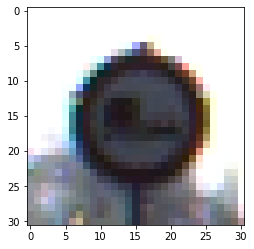

(31, 31, 3)


In [6]:
plt.imshow(xTrain[0])
plt.show()
print(xTrain[0].shape)

No passing for vehicles over 3.5 metric tons


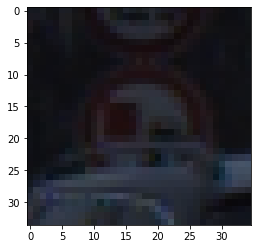

In [7]:
print(labels[yTrain[1000]])
plt.imshow(xTrain[1000])
plt.show()

In [8]:
def showImage(img):
    low, high = np.min(img), np.max(img)
    img = (img - low) / (high - low)
    plt.imshow(img.astype('float32'), cmap=plt.get_cmap('gray_r'))
    plt.show()

## Normalizer functions

In [6]:
def resizeImages(imgs, shape = (32, 32)):
    imgs = [resize(img, shape) for img in imgs]
    return np.array(imgs)

/255 normalization

In [10]:
def norm255(imgs):
    imgs = imgs.astype(np.float32)
    imgs /= 255.0
    return imgs

Shuffling

In [7]:
def shuffle(x, y, seed = 0):
    print('Shuffling...')
    np.random.seed(0)
    np.random.shuffle(x)
    np.random.seed(0)
    np.random.shuffle(y)

Mean normalization

In [12]:
def meanNorm(imgs):
    print('Mean norm...')
    means = np.mean(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(means)):
        normalized[i] -= means[i]
    return normalized

Standard normalization

In [13]:
def stdNorm(imgs):
    print('Std norm...')
    stds = np.std(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(stds)):
        normalized[i] /= stds[i]
    return normalized

Normalizing between -1, 1

In [14]:
def minMaxNorm(imgs):
    print('Min-Max norm...')
    low = np.min(imgs, axis=(1, 2, 3))
    high = np.max(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(imgs)):
        normalized[i] = (normalized[i] - low[i]) / (high[i] - low[i])
    return normalized * 2 - 1

Histogram normalization

In [79]:
def histogramStretching(img):
    p2 = np.percentile(img, 0)
    p98 = np.percentile(img, 85)
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

In [11]:
def histogramEqualization(img):
    imgEq = exposure.equalize_hist(img)
    return imgEq

In [81]:
def adaptiveHistogramEqualization(imgs):
    imgEq = exposure.equalize_adapthist(imgs, clip_limit=0.1)
    return imgEq

In [8]:
def histogramOrientedGradients(img):
    img = resize(img, (300, 300))
    img = histogramEqualization(img)
    data = hog(img, orientations=8, pixels_per_cell=(12, 12), cells_per_block=(1, 1), multichannel=True)
    return data

Applying histogram equalization methods

In [32]:
def applyHistogramNormalization(imgs, methods=[1]):
    normMethods = (histogramStretching, histogramEqualization, adaptiveHistogramEqualization)
    for method in methods:
        imgs = [ normMethods[method](img) for img in imgs ]
    return np.array(imgs)

In [9]:
def applyHOG(x, y):
    x = [histogramOrientedGradients(img) for img in x]
    shuffle(x, y)
    return x, y 

Applying mean, std, and mean max normalization

In [20]:
def applyNormalization(imgs):
    imgs = imgs.astype(np.float32)
    imgs = meanNorm(imgs)
    imgs = stdNorm(imgs)
    imgs = minMaxNorm(imgs)
    return imgs

General preprocessor method

In [21]:
def preprocess(x, y, histogramMethods=()):
    print('Histogram equalization...')
    x = applyHistogramNormalization(x, histogramMethods)
    x = applyNormalization(x)
    y = [ i for i in y ]
    shuffle(x, y)
    print('Done')
    return x, y

## Scikit preprocessor

In [15]:
def preprocessImages(imgs):
    imgs = imgs.reshape(imgs.shape[0], 32 * 32 * 3)
    print('Reshaped...')
    preprocessed = preprocessing.scale(imgs, axis=1)
    print('Scaled...')
    normalized = preprocessing.minmax_scale(preprocessed, axis=1)
    print('Normalized...')
    normalized = normalized * 2 - 1
    print('Normalized between -1 1')
    reshaped = normalized.reshape(normalized.shape[0], 32, 32, 3)
    return reshaped

## Preprocess datasets

In [22]:
xTrain = resizeImages(xTrain, (40, 40))
xTest = resizeImages(xTest, (40, 40))

In [28]:
xTrain = np.array(xTrain)
xTest = np.array(xTest)

In [33]:
xTrainSimple, yTrainSimple = preprocess(xTrain, yTrain)
xTestSimple, yTestSimple = preprocess(xTest, yTest)

xTrainStretch, yTrainStretch = preprocess(xTrain, yTrain, histogramMethods=[0])
xTestStretch, yTestStretch = preprocess(xTest, yTest, histogramMethods=[0])

xTrainEq, yTrainEq = preprocess(xTrain, yTrain, histogramMethods=[1])
xTestEq, yTestEq = preprocess(xTest, yTest, histogramMethods=[1])

xTrainAdEq, yTrainAdEq = preprocess(xTrain, yTrain, histogramMethods=[2])
xTestAdEq, yTestAdEq = preprocess(xTest, yTest, histogramMethods=[2])

Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Shuffling
Shuffling...
Done
Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Shuffling
Shuffling...
Done
Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Shuffling
Shuffling...
Done
Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Shuffling
Shuffling...
Done
Histogram equalization...


/home/adam/anaconda3/lib/python3.7/site-packages/skimage/exposure/exposure.py:124: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


Mean norm...
Std norm...
Min-Max norm...
Shuffling
Shuffling...
Done
Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Shuffling
Shuffling...
Done
Histogram equalization...


/home/adam/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Mean norm...
Std norm...
Min-Max norm...
Shuffling
Shuffling...
Done
Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Shuffling
Shuffling...
Done


In [12]:
xTrainHOG, yTrainHOG = applyHOG(xTrain, yTrain)
xTestHOG, yTestHOG = applyHOG(xTest, yTest)

/home/adam/anaconda3/lib/python3.7/site-packages/skimage/exposure/exposure.py:124: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


Shuffling...
Shuffling...


In [13]:
yTestHOG = yTest

In [17]:
elements = np.random.choice(xTest.shape[0], 4000)

Creating validation dataset

In [46]:
xValidSimple = xTestSimple[elements]
yValidSimple = np.array(yTestSimple)[elements]

xValidStretch = xTestStretch[elements]
yValidStretch =  np.array(yTestStretch)[elements]

xValidEq = xTestEq[elements]
yValidEq =  np.array(yTestEq)[elements]

xValidAdEq = xTestAdEq[elements]
yValidAdEq =  np.array(yTestAdEq)[elements]

In [20]:
xValidHOG = np.array(xTestHOG)[elements]
yValidHOG =  np.array(yTestHOG)[elements]

Sanity check

Ahead only


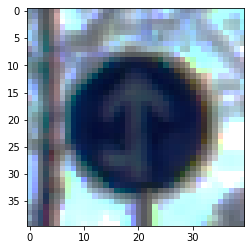

In [50]:
print(labels[yTestEq[1000]])
showImage(xTestEq[1000])

## Saving preprocessed images

In [60]:
model = {
    'x': {
        'train' : {
            'simple': xTrainSimple,
            'stretch': xTrainStretch,
            'eq': xTrainEq,
            'adeq': xTrainAdEq
        },
        'test' : {
            'simple': xTestSimple,
            'stretch': xTestStretch,
            'eq': xTestEq,
            'adeq': xTestAdEq
        },
        'valid' : {
            'simple': xValidSimple,
            'stretch': xValidStretch,
            'eq': xValidEq,
            'adeq': xValidAdEq
        }
    },
    'y' : {
        'train': yTrainSimple,
        'test' : yTestSimple,
        'valid' : yValidSimple
    },
    'labels': labels
}

In [23]:
model['x']['train']['hog'] = xTrainHOG
model['x']['test']['hog'] = xTestHOG
model['x']['valid']['hog'] = xValidHOG

In [24]:
modelSaver = ModelSaver(model=model, name='data/preprocessed_hist')
modelSaver.save()

## Load the images

In [22]:
modelSaver = ModelSaver(name='data/preprocessed_hist')
model = modelSaver.load()